# Import Necessary Modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image as Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# Load the 'EMNIST Balanced' Dataset & Examine it
Download the EMNIST Balanced dataset from https://www.kaggle.com/datasets/crawford/emnist 

In [2]:
# Load the EMNIST(Balanced) dataset from CSV files
train = read_csv(
    "./Datasets/emnist-balanced-train.csv", delimiter=',')
val = read_csv(
    "./Datasets/emnist-balanced-val.csv", delimiter=',')
class_mapping = read_csv("./Datasets/emnist-balanced-mapping.txt", delimiter=' ',
                         index_col=0, header=None, squeeze=True)

# Split the training and validation datasets into x(images) & y(labels)
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
del train
x_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]
del val

print("Number of images in our training data: " + str(len(x_train)))
print("Number of labels in our training data: " + str(len(y_train)))
print("Number of images in our validation data: " + str(len(x_val)))
print("Number of labels in our validation data: " + str(len(y_val)))
print()
print("Dimensions of x_train: " + str(x_train.shape))
print("Dimensions of x_val: " + str(x_val.shape))

Number of images in our training data: 112799
Number of labels in our training data: 112799
Number of images in our validation data: 18799
Number of labels in our validation data: 18799

Dimensions of x_train: (112799, 784)
Dimensions of x_val: (18799, 784)


# Preprocessing Our Image Datasets i.e x_train & x_val

**Define a function that will resize, flip(left to right) & rotate the input image**

In [3]:
# Define a function that will resize, flip(left to right) & rotate the input image
def resize_flip_rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

## Perform the Preprocessing

In [4]:
# -> Resize, flip & rotate training images
x_train = np.asarray(x_train)
x_train = np.apply_along_axis(resize_flip_rotate, 1, x_train)
x_val = np.asarray(x_val)
x_val = np.apply_along_axis(resize_flip_rotate, 1, x_val)

# Add a fourth column that indicates number of channels of the images present within the dataset
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

# -> Change our image data type to float32 data type
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

# Normalize our data by changing the range from (0 to 255) to (0 to 1)
x_train /= 255
x_val /= 255

# Build a Model

## Create a Model

In [5]:
# Initalize the model using Sequential class from Keras
model = Sequential()
# Add first convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                 input_shape=(28, 28, 1), padding="same"))
# Add a pooling layer which will downsample our data
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add 2nd convolutional layer
model.add(Conv2D(filters=64, kernel_size=(3, 3),
                 activation='relu', padding="same"))
# Add a pooling layer which will downsample our data
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add 3rd convolutional layer
model.add(Conv2D(filters=128, kernel_size=(
    3, 3), activation='relu', padding="same"))
# Add a pooling layer which will downsample our data
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add 4th convolutional layer
model.add(Conv2D(filters=256, kernel_size=(
    3, 3), activation='relu', padding="same"))
# Add a pooling layer which will downsample our data
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a flatten layer which will aid in flattening the input
model.add(Flatten())
# Add a dense/FC layer
model.add(Dense(units=256, activation='relu'))
# Add a droput layer which will aid in regularization
model.add(Dropout(0.5))
# Add a dense/FC layer
model.add(Dense(units=47, activation='softmax'))
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
# Print a summary of our model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 256)         2

## Define Callbacks

In [6]:
# Define a callback for saving only the best model during the training
checkpoint = ModelCheckpoint(filepath="./Trained Models/emnist_balanced_alphanum_classifier.h5",
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Define a callback to stop training when validation accuracy has stopped increasing
earlystop = EarlyStopping(monitor='val_accuracy',
                          mode='max',
                          patience=3,
                          restore_best_weights=True,
                          verbose=1)

# Put our callbacks into a list
callbacks = [earlystop, checkpoint]

# Train the Model

In [7]:
# Train our model and store the training results in a variable
model_train_result = model.fit(x=x_train,
                               y=y_train,
                               batch_size=32,
                               epochs=100,
                               callbacks=callbacks,
                               verbose=2,
                               validation_data=(x_val, y_val))

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.86217, saving model to ./Trained Models\emnist_balanced_alphanum_classifier.h5
3525/3525 - 22s - loss: 0.7288 - accuracy: 0.7682 - val_loss: 0.3969 - val_accuracy: 0.8622
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.86217 to 0.87287, saving model to ./Trained Models\emnist_balanced_alphanum_classifier.h5
3525/3525 - 22s - loss: 0.3997 - accuracy: 0.8605 - val_loss: 0.3634 - val_accuracy: 0.8729
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.87287 to 0.88180, saving model to ./Trained Models\emnist_balanced_alphanum_classifier.h5
3525/3525 - 22s - loss: 0.3529 - accuracy: 0.8741 - val_loss: 0.3391 - val_accuracy: 0.8818
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.88180 to 0.88382, saving model to ./Trained Models\emnist_balanced_alphanum_classifier.h5
3525/3525 - 23s - loss: 0.3196 - accuracy: 0.8836 - val_loss: 0.3382 - val_accuracy: 0.8838
Epoch 5/100

Epoch 00005: val_accuracy improved from 0.

# Evaluate Model's Performance

## Loss & Accuracy Charts

### Loss Chart

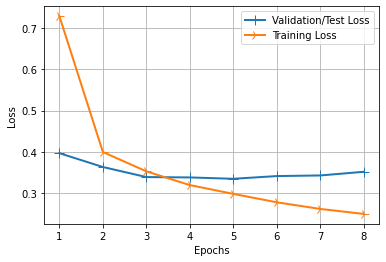

In [8]:
history_dict = model_train_result.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### Accuracy Chart

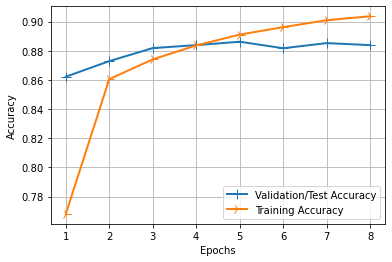

In [9]:
history_dict = model_train_result.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Classification Report for Validation Dataset

In [10]:
# Get model's predictions for each image in validation dataset
val_pred = model.predict(x_val, batch_size=32)
val_pred = np.argmax(val_pred, axis=1)

# Get class names
class_names = np.arange(start=0, stop=47, dtype='int64')
class_names = list(map(str, class_names))

# Get the classification report generated for validation dataset
print(classification_report(y_true=y_val,
                            y_pred=val_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.68      0.67      0.67       400
           1       0.57      0.67      0.62       400
           2       0.90      0.90      0.90       400
           3       0.99      0.99      0.99       400
           4       0.92      0.94      0.93       400
           5       0.96      0.91      0.93       400
           6       0.95      0.91      0.93       400
           7       0.96      0.99      0.98       400
           8       0.93      0.95      0.94       400
           9       0.66      0.83      0.74       400
          10       0.97      0.98      0.98       400
          11       0.95      0.97      0.96       400
          12       0.96      0.96      0.96       400
          13       0.93      0.93      0.93       400
          14       0.98      0.98      0.98       400
          15       0.71      0.57      0.63       400
          16       0.96      0.93      0.95       400
          17       0.97    

## Confusion Matrix for Validation Dataset

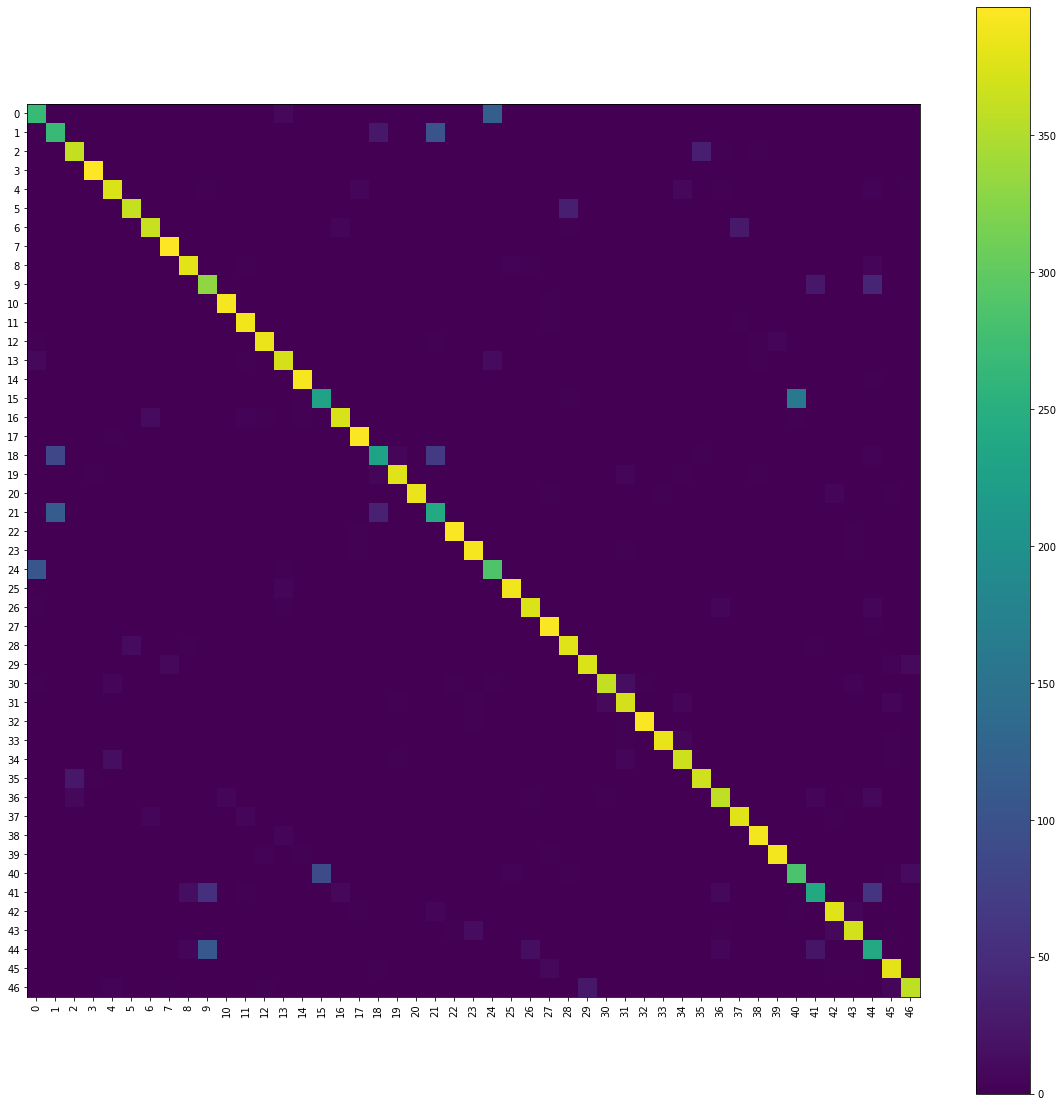

In [11]:
# Generate the confusion matrix for validation dataset
cnf_matrix = confusion_matrix(y_true=y_val, y_pred=val_pred)

# Display the confusion matrix
plt.figure(figsize=(20, 20))
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(class_names))
_ = plt.xticks(tick_marks, class_names, rotation=90)
_ = plt.yticks(tick_marks, class_names)